In [2]:
# 필수 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [3]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),              # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위 정규화
])

# 데이터셋 다운로드
train_dataset = datasets.MNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [ ]:
# 2. DNN 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)  # 입력층 (784 → 512)
        self.fc2 = nn.Linear(512, 256)    # 은닉층 (512 → 256)
        self.fc3 = nn.Linear(256, 10)     # 출력층 (256 → 10)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.log_softmax(self.fc3(x))

model = DNN().to(device)

In [ ]:
# 3. 학습 설정
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 4. 학습 루프
train_losses = []
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")

Epoch 1/5 | Loss: 0.2856
Epoch 2/5 | Loss: 0.1392
Epoch 3/5 | Loss: 0.1036
Epoch 4/5 | Loss: 0.0847
Epoch 5/5 | Loss: 0.0742


In [6]:
# 5. 성능 평가
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 성능 지표 계산
print("\n=== DNN 성능 지표 ===")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
print("\n=== Confusion Matrix ===")
print(confusion_matrix(all_labels, all_preds))


=== DNN 성능 지표 ===
F1 Score: 0.9658
Precision: 0.9664
Recall: 0.9659

=== Confusion Matrix ===
[[ 955    0    0    0    0    0   20    0    3    2]
 [   0 1120    6    2    0    0    2    2    3    0]
 [   0    0 1003    1    8    0    6    5    9    0]
 [   0    0   16  946    0    4    0   15   21    8]
 [   0    0    0    0  968    0    9    3    0    2]
 [   1    0    0   10    2  857    9    0    7    6]
 [   1    2    0    0    1    3  947    0    4    0]
 [   0    5    7    1   11    0    2  977    4   21]
 [   0    1    2    2    5    0    7    2  953    2]
 [   2    3    0    2   56    2    1    3    6  934]]


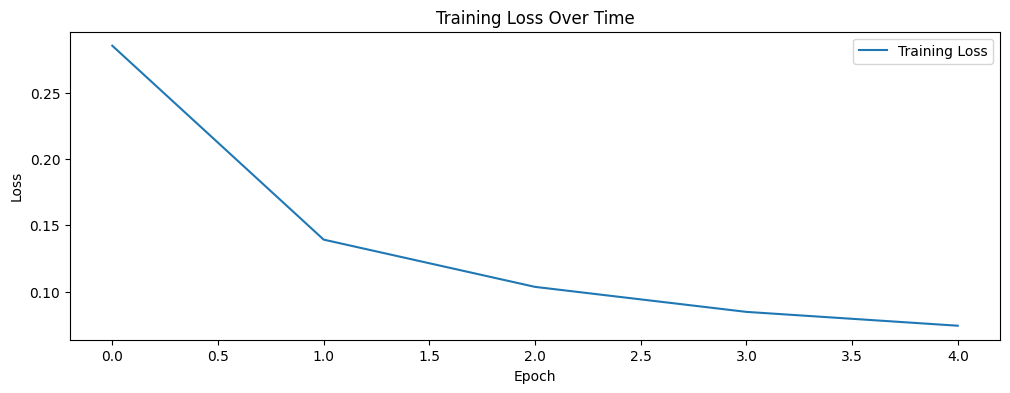

In [21]:
# 6. 학습 과정 시각화
plt.figure(figsize=(12,4))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()